In [2]:
import cimpy
from cimpy import CIM2DPsim
from cimpy.CIM2DPsim import Domain
from cimpy.cgmes_v2_4_15.Base import short_profile_name
import os
from pathlib import Path

import sys
sys.path.insert(0,'/home/mmo-cya/dpsim/build')
import dpsimpy

example_dir = Path(os.path.join('../cimpy/examples/sampledata/IEEE14')).resolve()

test_files = []
for file in example_dir.glob('*.xml'):
    test_files.append(str(file.absolute()))

imported_result = cimpy.cim_import(test_files, 'cgmes_v2_4_15')

CIM object Diagram created : 1 times
CIM object DiagramObjectPoint created : 168 times
CIM object DiagramObject created : 77 times
CIM object SvPowerFlow created : 16 times
CIM object SvVoltage created : 14 times
CIM object SvTapStep created : 5 times
CIM object TopologicalIsland created : 1 times
CIM object TopologicalNode created : 14 times
CIM object VoltageLimit created : 14 times
CIM object Terminal created : 58 times
CIM object VoltageLevel created : 14 times
CIM object OperationalLimitSet created : 56 times
CIM object PowerTransformer created : 5 times
CIM object ConformLoad created : 11 times
CIM object SubGeographicalRegion created : 1 times
CIM object RegulatingControl created : 5 times
CIM object BaseVoltage created : 4 times
CIM object PowerTransformerEnd created : 10 times
CIM object CurrentLimit created : 42 times
CIM object LoadArea created : 1 times
CIM object ConformLoadGroup created : 1 times
CIM object OperationalLimitType created : 2 times
CIM object RatioTapChanger

### Run Powerflow Simulation

In [3]:
name_pf = "IEEE14_ReaderTest_PFmmo"
dpsimpy.Logger.set_log_dir("logs/" + name_pf)

# create dpsim topology from cimpy object
system_PF = CIM2DPsim.CIM2DPsim(imported_result, Domain.PF, log_level=dpsimpy.LogLevel.info)

#set slack
system_PF.component("Gen_0001").modify_power_flow_bus_type(dpsimpy.PowerflowBusType.VD)

sim_pf = dpsimpy.Simulation(name_pf, dpsimpy.LogLevel.debug)
sim_pf.set_system(system_PF)
sim_pf.set_domain(dpsimpy.Domain.SP)
sim_pf.set_solver(dpsimpy.Solver.NRP)
#sim_pf.set_solver_component_behaviour(dpsimpy.SolverBehaviour.Initialization)
sim_pf.do_init_from_nodes_and_terminals(False)

logger = dpsimpy.Logger(name_pf)
sim_pf.add_logger(logger)
for node in system_PF.nodes:
    logger.log_attribute(node.name+'.V', 'v', node)
    logger.log_attribute(node.name+'.S', 's', node)
    
sim_pf.set_time_step(0.1)
sim_pf.set_final_time(0.5)
sim_pf.run()

[14:55:47.072358 IEEE14_ReaderTest_PFmmo info] Initialize simulation: IEEE14_ReaderTest_PFmmo
[14:55:47.073251 IEEE14_ReaderTest_PFmmo_PF_Solver warning] Unable to get base voltage at Bus_0010
[14:55:47.073262 IEEE14_ReaderTest_PFmmo_PF_Solver warning] Unable to get base voltage at Bus_0014
[14:55:47.073269 IEEE14_ReaderTest_PFmmo_PF_Solver warning] Unable to get base voltage at Bus_0011
[14:55:47.073276 IEEE14_ReaderTest_PFmmo_PF_Solver warning] Unable to get base voltage at Bus_0002
[14:55:47.073301 IEEE14_ReaderTest_PFmmo_PF_Solver warning] Unable to get base voltage at Bus_0012
[14:55:47.073308 IEEE14_ReaderTest_PFmmo_PF_Solver warning] Unable to get base voltage at Bus_0003
[14:55:47.073315 IEEE14_ReaderTest_PFmmo_PF_Solver warning] Unable to get base voltage at Bus_0013
[14:55:47.073941 IEEE14_ReaderTest_PFmmo info] Scheduling tasks.
[14:55:47.074526 IEEE14_ReaderTest_PFmmo info] Scheduling done.
[14:55:47.074529 IEEE14_ReaderTest_PFmmo info] Opening interfaces.
[14:55:47.074531 

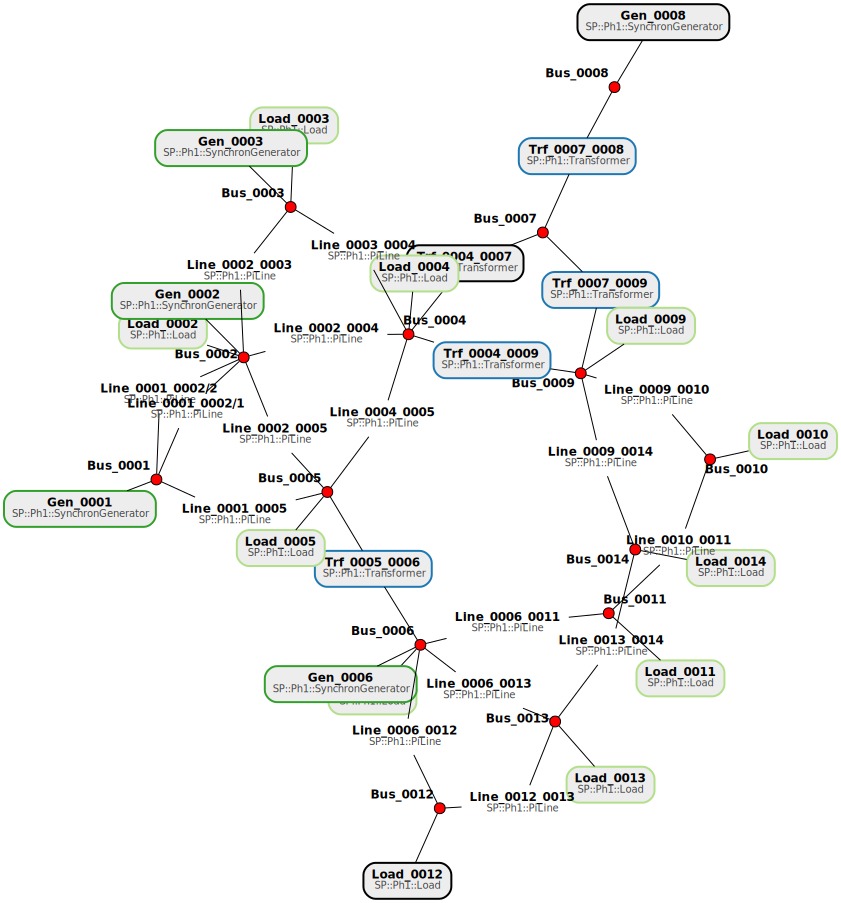

In [4]:
system_PF

### Read of results

In [5]:
from villas.dataprocessing.readtools import *
from villas.dataprocessing.timeseries import *
import urllib.request
import matplotlib.pyplot as plt

dpsim_result_file = 'logs/' + name_pf + '/' + name_pf + '.csv'
ts_dpsim_pf = read_timeseries_csv(dpsim_result_file)

column number: 28
results length: 6
real column names: []
complex column names: ['Bus_0001.S', 'Bus_0001.V', 'Bus_0002.S', 'Bus_0002.V', 'Bus_0003.S', 'Bus_0003.V', 'Bus_0004.S', 'Bus_0004.V', 'Bus_0005.S', 'Bus_0005.V', 'Bus_0006.S', 'Bus_0006.V', 'Bus_0007.S', 'Bus_0007.V', 'Bus_0008.S', 'Bus_0008.V', 'Bus_0009.S', 'Bus_0009.V', 'Bus_0010.S', 'Bus_0010.V', 'Bus_0011.S', 'Bus_0011.V', 'Bus_0012.S', 'Bus_0012.V', 'Bus_0013.S', 'Bus_0013.V', 'Bus_0014.S', 'Bus_0014.V']


In [6]:
dpsim_results = pd.DataFrame(columns=['Bus', 'Vmag [kV]', 'Vangle [rad]', 'P [MW]', 'Q [MVAr]'])
base_power = 100 #mw
for i in range(len(system_PF.nodes)):
    node_name = system_PF.nodes[i].name
    w_mw = 1e-6
    dpsim_results.loc[i] = ([node_name] + [round(np.absolute(ts_dpsim_pf[node_name + '.V'].values[-1]) / 1000, 4)]
        + [round(np.angle(ts_dpsim_pf[node_name + '.V'].values[-1]), 4)] 
        + [round(w_mw * np.real(ts_dpsim_pf[node_name + '.S'].values[-1]), 4)] 
        + [round(w_mw * np.imag(ts_dpsim_pf[node_name + '.S'].values[-1]), 5)])

dpsim_results



,Bus,Vmag [kV],Vangle [rad],P [MW],Q [MVAr]
0,Bus_0007,128.6706,-0.2648,-0.0000,-0.00000
1,Bus_0001,132.0000,0.0000,234.8369,-51.24815
2,Bus_0004,0.9780,-0.2041,-47.8000,3.90000
3,Bus_0010,31.6114,-0.3021,-9.0000,-5.80000
4,Bus_0014,31.2230,-0.3235,-14.9000,-5.00000
5,Bus_0011,32.1713,-0.2995,-3.5000,-1.80000
6,Bus_0002,132.0000,-0.1024,18.3000,35.09137
7,Bus_0009,0.9588,-0.2973,-29.5000,-16.60000
8,Bus_0006,132.0000,-0.2923,-11.2000,32.43200
9,Bus_0008,1.0000,-0.2648,0.0000,14.31865


In [7]:
# get powerfactory results
pf_results = CIM2DPsim.get_powerflow_results(imported_result)
pf_results

,Bus,Vmag [kV],Vangle [rad],P [MW],Q [MVAr]
0,Bus_0007,1.04524,-0.234906,0.0000,0.0000
1,Bus_0001,139.92000,0.000000,232.5290,-22.8611
2,Bus_0004,135.57400,-0.181125,-47.8000,-47.8000
3,Bus_0010,33.92010,-0.267473,-9.0000,-9.0000
4,Bus_0014,33.58390,-0.286218,-14.9000,-14.9000
5,Bus_0011,34.48880,-0.265601,-3.5000,-3.5000
6,Bus_0002,137.94000,-0.086481,18.3001,7.8627
7,Bus_0009,33.92530,-0.263161,-29.5000,-29.5000
8,Bus_0006,35.31000,-0.259719,-11.2000,37.4425
9,Bus_0008,11.99000,-0.234904,0.0000,27.6962


### Difference between PowerFactory and DPsim

In [8]:
difference_vmag = pf_results['Vmag [kV]'] - dpsim_results['Vmag [kV]']
difference_vangle = pf_results['Vangle [rad]'] - dpsim_results['Vangle [rad]']

#base power = 100MW
difference_p = (pf_results['P [MW]'] - dpsim_results['P [MW]'])
difference_q = (pf_results['Q [MVAr]'] - dpsim_results['Q [MVAr]'])
difference = {"Bus": pf_results['Bus'], "Vmag [kV]": difference_vmag, "Vangle [rad]": difference_vangle, "P [MW]": difference_p, "Q [MVAr]": difference_q}
difference = pd.DataFrame(difference)

difference

,Bus,Vmag [kV],Vangle [rad],P [MW],Q [MVAr]
0,Bus_0007,-127.62536,0.029894,0.0000,0.00000
1,Bus_0001,7.92000,0.000000,-2.3079,28.38705
2,Bus_0004,134.59600,0.022975,0.0000,-51.70000
3,Bus_0010,2.30870,0.034627,0.0000,-3.20000
4,Bus_0014,2.36090,0.037282,0.0000,-9.90000
5,Bus_0011,2.31750,0.033899,0.0000,-1.70000
6,Bus_0002,5.94000,0.015919,0.0001,-27.22867
7,Bus_0009,32.96650,0.034139,0.0000,-12.90000
8,Bus_0006,-96.69000,0.032581,0.0000,5.01050
9,Bus_0008,10.99000,0.029896,0.0000,13.37755


### Run dynamic simulation

In [ ]:
name_dyn = "IEEE14_ReaderTest_Dyn"
dpsimpy.Logger.set_log_dir("logs/" + name_dyn)

# create dpsim topology from cimpy object
system_SP = CIM2DPsim.CIM2DPsim(imported_result, Domain.SP, log_level=dpsimpy.LogLevel.debug)

sim = dpsimpy.Simulation(name_dyn, dpsimpy.LogLevel.debug)
sim.set_system(system_SP)
sim.set_domain(dpsimpy.Domain.SP)

sim.do_init_from_nodes_and_terminals(True)
sim.set_direct_solver_implementation(dpsimpy.DirectLinearSolverImpl.SparseLU)
sim.do_system_matrix_recomputation(True)

# initialize node voltages of dynamic system
system_SP.init_with_powerflow(system_PF)

#set terminal power of generators in dpsim
for comp in ["Gen_0001", "Gen_0002", "Gen_0003", "Gen_0006", "Gen_0008"]:
    complex_power = system_PF.component(comp).get_apparent_power()
    print(complex_power)
    system_SP.component(comp).get_terminal(index=0).set_power(-complex_power)
            
#sw_event_1 = dpsimpy.event.SwitchEvent(1.0, switch, True)
#sim.add_event(sw_event_1)
    
#sw_event_2 = dpsimpy.event.SwitchEvent(1.1, switch, False)
#sim.add_event(sw_event_2)

logger = dpsimpy.Logger(name_dyn)
sim.add_logger(logger)
for node in system_SP.nodes:
    logger.log_attribute(node.name +'.V', 'v', node)
    
sim.set_time_step(1e-3)
sim.set_final_time(1)
sim.run()

: 

: 

: 

: 

In [ ]:
name_dyn

### Read results

In [ ]:
from villas.dataprocessing.readtools import *
from villas.dataprocessing.timeseries import *

# read Simulink log file

file_path = os.getcwd() + "/logs/" + name_dyn + "/" + name_dyn + ".csv"
ts_dpsim = read_timeseries_dpsim(file_path)

column number: 14
results length: 1001
real column names: []
complex column names: ['Bus_0001.V', 'Bus_0002.V', 'Bus_0003.V', 'Bus_0004.V', 'Bus_0005.V', 'Bus_0006.V', 'Bus_0007.V', 'Bus_0008.V', 'Bus_0009.V', 'Bus_0010.V', 'Bus_0011.V', 'Bus_0012.V', 'Bus_0013.V', 'Bus_0014.V']


### Plot Results

<function matplotlib.pyplot.show(close=None, block=None)>

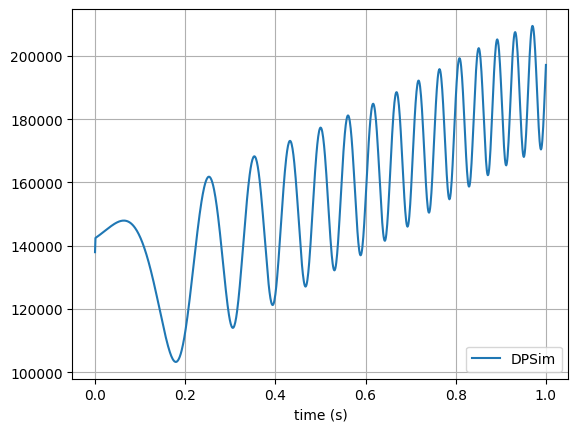

In [ ]:
import matplotlib.pyplot as plt

plt.plot(ts_dpsim['Bus_0001.V'].time, ts_dpsim['Bus_0007.V'].abs().values, label='DPSim')
plt.legend(loc='lower right')
plt.xlabel('time (s)')
#plt.ylabel(ylabels[varname_dpsim])
plt.grid()
#plt.xlim([t_begin, t_end])
plt.show